In [140]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly
import random

In [141]:
df_channels = pd.read_csv(r'bases\channels.csv')
df_deliveries = pd.read_csv(r'bases\deliveries.csv')
df_drivers = pd.read_csv(r'bases\drivers.csv')
df_hubs = pd.read_csv(r'bases\hubs.csv')
df_orders = pd.read_csv(r'bases\orders.csv')
df_stores = pd.read_csv(r'bases\stores.csv')
df_payments = pd.read_csv(r'bases\payments.csv')


Unindo os dataframes

In [142]:
df = pd.merge(df_orders, df_stores, on='store_id')
df = pd.merge(df, df_hubs, on='hub_id')
df = pd.merge(df, df_channels, on='channel_id')
df = pd.merge(df, df_payments, on='payment_order_id')
df = pd.merge(df, df_deliveries, on='delivery_order_id')
df = pd.merge(df, df_drivers, on='driver_id')

In [143]:
print(df.columns)

Index(['order_id', 'store_id', 'channel_id', 'payment_order_id',
       'delivery_order_id', 'order_status', 'order_amount',
       'order_delivery_fee', 'order_delivery_cost', 'order_created_hour',
       'order_created_minute', 'order_created_day', 'order_created_month',
       'order_moment_created', 'order_moment_accepted', 'order_moment_ready',
       'order_moment_collected', 'order_moment_in_expedition',
       'order_moment_delivering', 'order_moment_delivered',
       'order_moment_finished', 'order_metric_collected_time',
       'order_metric_paused_time', 'order_metric_production_time',
       'order_metric_walking_time', 'order_metric_expediton_speed_time',
       'order_metric_transit_time', 'order_metric_cycle_time', 'hub_id',
       'store_segment', 'store_plan_price', 'store_latitude',
       'store_longitude', 'hub_city', 'hub_latitude', 'hub_longitude',
       'channel_type', 'payment_id', 'payment_amount', 'payment_fee',
       'payment_method', 'payment_status', 'de

Agora com o dataframe todo unido, dropar colunas de id que não agregam no modelo

In [144]:
#função base que muda o dataframe

grupo_pagamento = {
'DEBIT': 'CARD',
'CREDIT': 'CARD',
'DEBIT_STORE': 'CARD',
'CREDIT_STORE': 'CARD',
'INSTALLMENT_CREDIT_STORE': 'CARD',
'MEAL_BENEFIT': 'OTHER',
'STORE_DIRECT_PAYMENT': 'OTHER',
'PAYMENT_LINK': 'OTHER',
'MONEY': 'OTHER',
'BANK_TRANSFER_DC': 'OTHER',
'VOUCHER_DC': 'VOUCHER',
'VOUCHER_OL': 'VOUCHER',
'VOUCHER_STORE': 'VOUCHER'
}

def preparacao(df):
    df = df.drop(columns=['store_id','channel_id','payment_order_id','delivery_order_id','hub_id','payment_id','delivery_id', 'driver_id','order_moment_accepted', 'order_moment_ready',
        'order_moment_collected', 'order_moment_in_expedition',
        'order_moment_delivering', 'order_moment_delivered'])

    df = df[~df['order_status'].isin(['CANCELED'])]
    df = df[~df['delivery_status'].isin(['DELIVERING'])]
    df = df[~df['payment_status'].isin(['CHARGEBACK', 'AWAITING'])]
    df['payment_method'] = df['payment_method'].replace(grupo_pagamento)
    
    df = df.drop(columns=['order_status','payment_status','delivery_status'])

    #duplicadas
    df = df.drop_duplicates()

    df = df.dropna(subset=['delivery_distance_meters','store_latitude','store_longitude','order_moment_finished'])

    df['order_delivery_cost'] = df['order_delivery_cost'].fillna(0.0)
    df['store_plan_price'] = df['store_plan_price'].fillna(0.0)

    df['order_moment_created'] = pd.to_datetime(df['order_moment_created'])
    df['order_moment_finished'] = pd.to_datetime(df['order_moment_finished'])

    # Calcular a diferença entre as duas colunas em minutos
    df['order_metric'] = (df['order_moment_finished'] - df['order_moment_created']).dt.total_seconds() / 60

    # Exibir o DataFrame resultante
    print(df['order_metric'])

    df = df.loc[df['order_metric'] >= 0]

    df = df.drop_duplicates()
    df = df.loc[df['order_metric_transit_time'] >= 0]
    df = df.loc[df['order_metric_walking_time'] >= 0]
    df = df.loc[df['order_metric_paused_time'] >= 0]
    df = df.loc[df['order_metric_collected_time'] >= 0]



In [145]:
df = df.drop(columns=['store_id','channel_id','payment_order_id','delivery_order_id','hub_id','payment_id','delivery_id', 'driver_id','order_moment_accepted', 'order_moment_ready',
       'order_moment_collected', 'order_moment_in_expedition',
       'order_moment_delivering', 'order_moment_delivered'])

print(df.columns)

Index(['order_id', 'order_status', 'order_amount', 'order_delivery_fee',
       'order_delivery_cost', 'order_created_hour', 'order_created_minute',
       'order_created_day', 'order_created_month', 'order_moment_created',
       'order_moment_finished', 'order_metric_collected_time',
       'order_metric_paused_time', 'order_metric_production_time',
       'order_metric_walking_time', 'order_metric_expediton_speed_time',
       'order_metric_transit_time', 'order_metric_cycle_time', 'store_segment',
       'store_plan_price', 'store_latitude', 'store_longitude', 'hub_city',
       'hub_latitude', 'hub_longitude', 'channel_type', 'payment_amount',
       'payment_fee', 'payment_method', 'payment_status',
       'delivery_distance_meters', 'delivery_status', 'driver_modal',
       'driver_type'],
      dtype='object')


limpeza inciail dos dados

analise de cada coluna

In [146]:
print(df.columns)


Index(['order_id', 'order_status', 'order_amount', 'order_delivery_fee',
       'order_delivery_cost', 'order_created_hour', 'order_created_minute',
       'order_created_day', 'order_created_month', 'order_moment_created',
       'order_moment_finished', 'order_metric_collected_time',
       'order_metric_paused_time', 'order_metric_production_time',
       'order_metric_walking_time', 'order_metric_expediton_speed_time',
       'order_metric_transit_time', 'order_metric_cycle_time', 'store_segment',
       'store_plan_price', 'store_latitude', 'store_longitude', 'hub_city',
       'hub_latitude', 'hub_longitude', 'channel_type', 'payment_amount',
       'payment_fee', 'payment_method', 'payment_status',
       'delivery_distance_meters', 'delivery_status', 'driver_modal',
       'driver_type'],
      dtype='object')


In [148]:
#order_status
print(df['order_status'].value_counts())

df = df[~df['order_status'].isin(['CANCELED'])]

['FINISHED' 'CANCELED']
order_status
FINISHED    287457
CANCELED         2
Name: count, dtype: int64


In [125]:
#como todos valores são finished será retirada
df = df.drop(columns='order_status')

print(df['payment_method'].value_counts())


payment_method
ONLINE                      223698
VOUCHER                      34467
DEBIT                         8943
MEAL_BENEFIT                  5131
STORE_DIRECT_PAYMENT          4780
CREDIT                        3667
DEBIT_STORE                   1573
VOUCHER_STORE                 1241
PAYMENT_LINK                  1144
CREDIT_STORE                   951
MONEY                          856
INSTALLMENT_CREDIT_STORE       350
VOUCHER_DC                     249
BANK_TRANSFER_DC               236
VOUCHER_OL                     173
Name: count, dtype: int64


In [126]:
grupo_pagamento = {
    'DEBIT': 'CARD',
    'CREDIT': 'CARD',
    'DEBIT_STORE': 'CARD',
    'CREDIT_STORE': 'CARD',
    'INSTALLMENT_CREDIT_STORE': 'CARD',
    'MEAL_BENEFIT': 'OTHER',
    'STORE_DIRECT_PAYMENT': 'OTHER',
    'PAYMENT_LINK': 'OTHER',
    'MONEY': 'OTHER',
    'BANK_TRANSFER_DC': 'OTHER',
    'VOUCHER_DC': 'VOUCHER',
    'VOUCHER_OL': 'VOUCHER',
    'VOUCHER_STORE': 'VOUCHER'
}

# Substituindo os valores da coluna 'payment_method' de acordo com o mapeamento
df['payment_method'] = df['payment_method'].replace(grupo_pagamento)

# Contando os novos valores únicos após a substituição
print(df['payment_method'].value_counts())

payment_method
ONLINE     223698
VOUCHER     36130
CARD        15484
OTHER       12147
Name: count, dtype: int64


In [127]:
print(df['payment_status'].value_counts())

payment_status
PAID          287111
CHARGEBACK       335
AWAITING          13
Name: count, dtype: int64


In [128]:
#retirar CHARGEBACK e AWAITING e por fim retirar a coluna

df = df[~df['payment_status'].isin(['CHARGEBACK', 'AWAITING'])]

# Verificando se as linhas foram removidas corretamente
df = df.drop(columns='payment_status')

print(df['delivery_status'].value_counts())

delivery_status
DELIVERED     286995
DELIVERING       116
Name: count, dtype: int64


In [129]:
#retirar DELIVERING e por fim retirar a coluna

df = df[~df['delivery_status'].isin(['DELIVERING'])]

# Verificando se as linhas foram removidas corretamente
df = df.drop(columns='delivery_status')

driver_type
FREELANCE            204208
LOGISTIC OPERATOR     82787
Name: count, dtype: int64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287459 entries, 0 to 287458
Data columns (total 33 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   order_status                       287459 non-null  object 
 1   order_amount                       287459 non-null  int64  
 2   order_delivery_fee                 287459 non-null  int64  
 3   order_delivery_cost                284781 non-null  float64
 4   order_created_hour                 287459 non-null  int64  
 5   order_created_minute               287459 non-null  int64  
 6   order_created_day                  287459 non-null  int64  
 7   order_created_month                287459 non-null  int64  
 8   order_moment_created               287459 non-null  object 
 9   order_moment_finished              287455 non-null  object 
 10  order_metric_collected_time        262718 non-null  float64
 11  order_metric_paused_time           2481

In [7]:
df = df.drop_duplicates()

In [8]:
#valores nulos
print(df.isnull().sum())

order_status                             0
order_amount                             0
order_delivery_fee                       0
order_delivery_cost                   1639
order_created_hour                       0
order_created_minute                     0
order_created_day                        0
order_created_month                      0
order_moment_created                     0
order_moment_finished                    3
order_metric_collected_time          23592
order_metric_paused_time             37761
order_metric_production_time          7509
order_metric_walking_time            41586
order_metric_expediton_speed_time     9421
order_metric_transit_time             2338
order_metric_cycle_time                174
store_segment                            0
store_plan_price                     61654
store_latitude                         737
store_longitude                        737
hub_city                                 0
hub_latitude                             0
hub_longitu

In [9]:
df = df.dropna(subset=['delivery_distance_meters','store_latitude','store_longitude','order_moment_finished'])

In [10]:
print(df.isnull().sum())

order_status                             0
order_amount                             0
order_delivery_fee                       0
order_delivery_cost                   1617
order_created_hour                       0
order_created_minute                     0
order_created_day                        0
order_created_month                      0
order_moment_created                     0
order_moment_finished                    0
order_metric_collected_time          23055
order_metric_paused_time             37224
order_metric_production_time          6989
order_metric_walking_time            41040
order_metric_expediton_speed_time     8894
order_metric_transit_time             2319
order_metric_cycle_time                171
store_segment                            0
store_plan_price                     61132
store_latitude                           0
store_longitude                          0
hub_city                                 0
hub_latitude                             0
hub_longitu

order_delivery_cost

tem 1600 valores vazios. como a coluna é de custo, colocar 0 nos NaN

store_plan_price

como alguma precos sao nulos, valores NaN equivalem ao preco de plano 0

In [11]:
df['order_delivery_cost'] = df['order_delivery_cost'].fillna(0.0)
df['store_plan_price'] = df['store_plan_price'].fillna(0.0)

In [12]:
print(df['order_moment_created'])

0           4/9/2021 3:49:59 PM
1          1/29/2021 9:19:06 PM
2          2/18/2021 8:49:48 PM
3          1/9/2021 10:35:40 PM
4           1/3/2021 4:22:42 PM
                  ...          
287454    3/29/2021 10:38:13 PM
287455      3/1/2021 5:04:20 PM
287456      4/8/2021 4:46:18 PM
287457      4/7/2021 4:35:15 PM
287458    2/15/2021 12:05:27 AM
Name: order_moment_created, Length: 274691, dtype: object


In [13]:
# Converter as colunas de string para datetime
df['order_moment_created'] = pd.to_datetime(df['order_moment_created'])
df['order_moment_finished'] = pd.to_datetime(df['order_moment_finished'])

# Calcular a diferença entre as duas colunas em minutos
df['order_metric'] = (df['order_moment_finished'] - df['order_moment_created']).dt.total_seconds() / 60

# Exibir o DataFrame resultante
print(df['order_metric'])

df = df.loc[df['order_metric'] >= 0]

C:\Users\matus\AppData\Local\Temp\ipykernel_16968\2009913860.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\matus\AppData\Local\Temp\ipykernel_16968\2009913860.py:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



0          37.400000
1          37.433333
2          58.316667
3          38.100000
4          44.850000
             ...    
287454     22.716667
287455    307.500000
287456    547.116667
287457    168.916667
287458     46.550000
Name: order_metric, Length: 274691, dtype: float64


In [14]:
print(df.isnull().sum())

order_status                             0
order_amount                             0
order_delivery_fee                       0
order_delivery_cost                      0
order_created_hour                       0
order_created_minute                     0
order_created_day                        0
order_created_month                      0
order_moment_created                     0
order_moment_finished                    0
order_metric_collected_time          23029
order_metric_paused_time             37192
order_metric_production_time          6974
order_metric_walking_time            41006
order_metric_expediton_speed_time     8872
order_metric_transit_time             2195
order_metric_cycle_time                 47
store_segment                            0
store_plan_price                         0
store_latitude                           0
store_longitude                          0
hub_city                                 0
hub_latitude                             0
hub_longitu

valores duplicados

In [15]:
df = df.drop_duplicates()

valores inconsistentes

In [16]:
coluna = 'order_amount'

valores_negativos = df.loc[df[coluna] < 0, coluna]

# Imprimir os valores negativos
print(valores_negativos)

Series([], Name: order_amount, dtype: int64)


In [17]:
#valores que são impossíveis de serem negativos

df = df.loc[df['order_metric_transit_time'] >= 0]
df = df.loc[df['order_metric_walking_time'] >= 0]
df = df.loc[df['order_metric_paused_time'] >= 0]
df = df.loc[df['order_metric_collected_time'] >= 0]

outliers

as colunas que tem outliers tem quantidade consideravel e eu acho valido considerá-los, talvez no futuro retirar casos muito fora da curva

In [18]:
def calcula_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    diff = q3 - q1
    lim_inf = q1 - 1.5 * diff
    lim_sup = q3 + 1.5 * diff
    outliers = column[(column < lim_inf) | (column > lim_sup)] # Definição de outliers pelos percentis e limites
    return outliers, lim_inf, lim_sup

# Função para contar outliers e calcular a porcentagem
def conta_outliers(df):
    outlier_info = pd.DataFrame(columns=['Coluna', 'Outliers', 'Porcentagem', 'lim_inf', 'lim_sup']) # Criando um novo DataFrame
    for col in df.select_dtypes(include=['int', 'float']): # Loop para verificar cada coluna numérica
        outliers, lim_inf, lim_sup = calcula_outliers(df[col]) # Chamando a função para calcular outliers
        outlier_count = len(outliers) # Verificando o tamanho da lista
        percentage = (outlier_count / len(df)) * 100 # Porcentagem de outliers
        outlier_info.loc[len(outlier_info)] = [col, outlier_count, percentage, lim_inf, lim_sup] # Atribuindo valores usando .loc[]
    return outlier_info # Retornando DataFrame

outlier_df = conta_outliers(df)
print(outlier_df)

                               Coluna  Outliers  Porcentagem      lim_inf  \
0                        order_amount     11654     5.031952   -74.500000   
1                  order_delivery_fee        64     0.027634   -16.500000   
2                 order_delivery_cost      9179     3.963299     0.500000   
3                  order_created_hour     20302     8.765976     4.500000   
4                order_created_minute         0     0.000000   -31.000000   
5                   order_created_day         0     0.000000   -13.500000   
6                 order_created_month         0     0.000000    -1.000000   
7         order_metric_collected_time     14657     6.328584    -3.000000   
8            order_metric_paused_time     20180     8.713299    -5.000000   
9        order_metric_production_time      9083     3.921848    -9.000000   
10          order_metric_walking_time     10871     4.693869    -2.500000   
11  order_metric_expediton_speed_time     15772     6.810017    -5.000000   

In [19]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
order_amount,231600.0,91.878959,0.0,38.0,66.0,113.0,15962.0,133.742121
order_delivery_fee,231600.0,5.509685,0.0,0.0,6.0,11.0,990.0,5.818
order_delivery_cost,231600.0,7.05082,0.0,5.0,7.0,8.0,156.0,2.866303
order_created_hour,231600.0,16.89886,0.0,15.0,17.0,22.0,23.0,6.051105
order_created_minute,231600.0,29.358955,0.0,14.0,29.0,44.0,59.0,17.219125
order_created_day,231600.0,16.033364,1.0,9.0,16.0,24.0,31.0,8.739757
order_created_month,231600.0,2.663877,1.0,2.0,3.0,4.0,4.0,1.096669
order_moment_created,231600,2021-03-07 13:39:35.782357504,2021-01-01 02:32:51,2021-02-07 16:45:21.249999872,2021-03-11 22:11:30,2021-04-03 19:49:53.750000128,2021-04-30 23:59:26,NaN
order_moment_finished,231600,2021-03-07 15:09:15.586446336,2021-01-01 14:50:20,2021-02-07 17:55:39.500000,2021-03-11 23:03:07.500000,2021-04-03 21:07:17.249999872,2021-05-07 23:10:17,NaN
order_metric_collected_time,231600.0,2.037638,0.0,0.0,1.0,2.0,1887.0,8.290604


heatmap

In [131]:
print(df.columns)

Index(['order_id', 'order_amount', 'order_delivery_fee', 'order_delivery_cost',
       'order_created_hour', 'order_created_minute', 'order_created_day',
       'order_created_month', 'order_moment_created', 'order_moment_finished',
       'order_metric_collected_time', 'order_metric_paused_time',
       'order_metric_production_time', 'order_metric_walking_time',
       'order_metric_expediton_speed_time', 'order_metric_transit_time',
       'order_metric_cycle_time', 'store_segment', 'store_plan_price',
       'store_latitude', 'store_longitude', 'hub_city', 'hub_latitude',
       'hub_longitude', 'channel_type', 'payment_amount', 'payment_fee',
       'payment_method', 'delivery_distance_meters', 'driver_modal',
       'driver_type'],
      dtype='object')


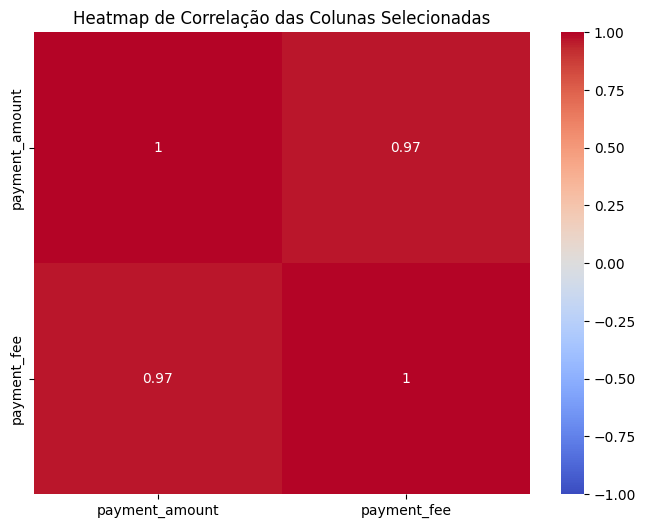

In [133]:
#Análise colunas midiáticas

colunas = ['payment_amount','payment_fee']
df_subset = df[colunas]

# Criar o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_subset.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlação das Colunas Selecionadas')
plt.show()

Muito correlacionado, utilizar apenas um no modelo ESCOLHER QUAL

In [ ]:
df = df.drop(columns='payment_fee')

In [137]:
# Selecionando apenas as colunas numéricas do DataFrame
numeric_columns = df.select_dtypes(include=['int', 'float'])

# Exibindo as colunas numéricas
print(numeric_columns)


        order_id  order_amount  order_delivery_fee  order_delivery_cost  \
0       89066010            64                   6                  5.0   
1       74452603            74                  11                  6.0   
2       78635930            82                   9                  8.0   
3       70338727            85                   9                  8.0   
4       68874888           107                  11                  6.0   
...          ...           ...                 ...                  ...   
287454  86909485            26                   0                  5.0   
287455  80836804           579                   9                  0.0   
287456  88807164            52                   6                  0.0   
287457  88616043            23                   0                  0.0   
287458  77819085            74                   1                  8.0   

        order_created_hour  order_created_minute  order_created_day  \
0                       15  

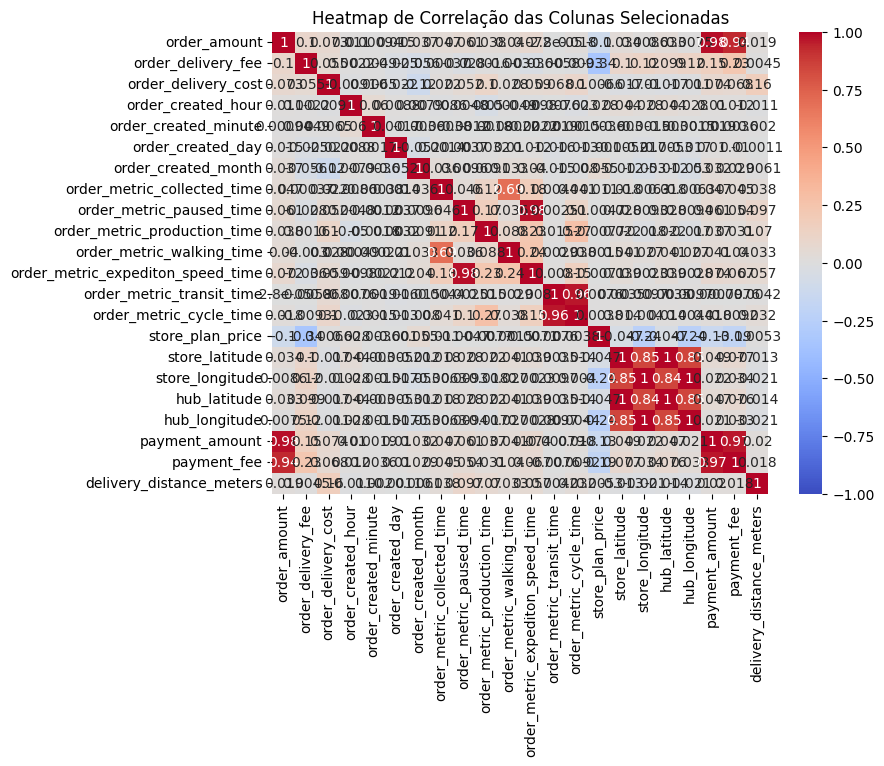

In [139]:
colunas = ['order_amount', 'order_delivery_fee', 'order_delivery_cost','order_created_hour','order_created_minute', 'order_created_day','order_created_month','order_metric_collected_time', 'order_metric_paused_time','order_metric_production_time', 'order_metric_walking_time','order_metric_expediton_speed_time', 'order_metric_transit_time','order_metric_cycle_time', 'store_plan_price','store_latitude', 'store_longitude', 'hub_latitude','hub_longitude', 'payment_amount', 'delivery_distance_meters']
df_subset = df[colunas]

# Criar o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_subset.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlação das Colunas Selecionadas')
plt.show()
